In [1]:
%load_ext autoreload
%autoreload 2
import sys
import transdimensional_spline_fitting as tsf
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.stats import norm
from scipy.optimize import minimize
from functools import partial
import matplotlib as mpl
import pandas as pd
from scipy.interpolate import interp1d

mpl.rcParams.update(mpl.rcParamsDefault)

import pygwb
import bilby
import astropy.cosmology
from copy import deepcopy
from pygwb.baseline import Baseline
import seaborn as sns

from popstock_tsf_helper import *

# Signficantly speeds things up
import lal
lal.swig_redirect_standard_output_error(False)

/home/tknapp/.local/lib/python3.9/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


True

In [2]:
R0 = 31.4
H0 = astropy.cosmology.Planck18.H0.to(astropy.units.s**-1).value

class SmoothCurveDataObj(object):
    """
    A data class that can be used with our spline model
    """
    def __init__(self, data_xvals, data_yvals, data_errors):
        self.data_xvals = data_xvals
        self.data_yvals = data_yvals
        self.data_errors = data_errors

class FitRedshift(tsf.BaseSplineModel):
    """
    Example of subclassing `BaseSplineModel` to create a likelihood
    that can then be used for sampling.

    Assumes use with `ArbitraryCurveDataObj`

    You also need to create a simple data class to go along with this. This
    allows the sampler to be used with arbitrary forms of data...
    """
    def ln_likelihood(self, config, heights):
        """
        Simple Gaussian log likelihood where the data are just simply
        points in 2D space that we're trying to fit.

        This could be something more complicated, though, of course. For example,
        You might create your model from the splines (`model`, below) and then use that
        in some other calculation to put it into the space for the data you have.

        :param data_obj: `ArbtraryCurveDataObj` -- an instance of the data object class associated with this likelihood.
        :return: log likelihood
        """
        # be careful of `evaluate_interp_model` function! it does require you to give a list of xvalues,
        # which don't exist in the base class!
        redshift_model = 10**self.evaluate_interp_model(np.log10(bbh_pickle.ref_zs), heights, config, log_xvals=True)
        
        model = bbh_pickle.eval(R0, redshift_model, self.data.data_xvals)
        
        return np.sum(norm.logpdf(model - self.data.data_yvals, scale=self.data.data_errors))

class FitOmega(tsf.BaseSplineModel):
    """
    Example of subclassing `BaseSplineModel` to create a likelihood
    that can then be used for sampling.

    Assumes use with `ArbitraryCurveDataObj`

    You also need to create a simple data class to go along with this. This
    allows the sampler to be used with arbitrary forms of data...
    """

    
    def ln_likelihood(self, config, heights, knots):
        """
        Simple Gaussian log likelihood where the data are just simply
        points in 2D space that we're trying to fit.

        This could be something more complicated, though, of course. For example,
        You might create your model from the splines (`model`, below) and then use that
        in some other calculation to put it into the space for the data you have.

        :param data_obj: `ArbtraryCurveDataObj` -- an instance of the data object class associated with this likelihood.
        :return: log likelihood
        """
        # be careful of `evaluate_interp_model` function! it does require you to give a list of xvalues,
        # which don't exist in the base class!
        omega_model = 10**self.evaluate_interp_model(np.log10(self.data.data_xvals), heights, config, np.log10(knots))
        # print(omega_model)
        # print(self.data.data_yvals)
        # print(self.data.data_errors)

        return np.sum(norm.logpdf(omega_model - self.data.data_yvals, scale=self.data.data_errors))

# Generate Data

In [ ]:
# set all the variables to run the cells below more efficiently: 

# define the range of frequencies we want to generate data over
freqs = np.arange(20, 100, 0.03125)

# 168 days of observing time
T = 168 * 24 * 60 * 60   

N_samples = 100_000
N_offset = 90_000

# generate data given a keyword ['BPL', 'squiggly', 'Sachdev'] - currently using a txt file for the Sachdev curve
sig_type = 'BPL'


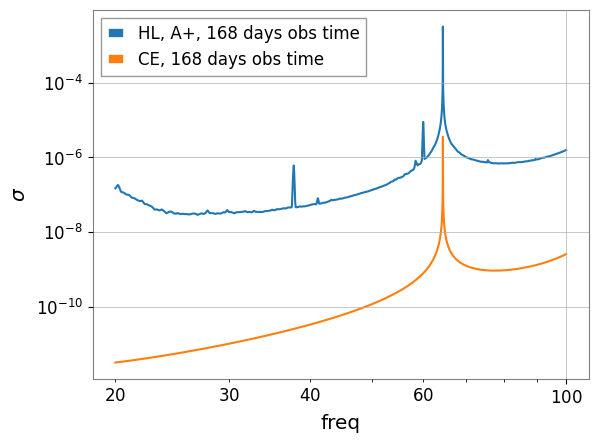

In [61]:
# get the sigma curves based on detector pairs
HL_sigma = get_sigma_from_noise_curves(['H1', 'L1'], freqs, T)
CE_sigma = get_sigma_from_noise_curves(['CE'], freqs, T)

# plotting the sigma curves
plt.loglog(freqs, HL_sigma, label = 'HL, A+, 168 days obs time')
plt.loglog(freqs, CE_sigma, label = 'CE, 168 days obs time')
plt.xlabel('freq')
plt.ylabel('$\sigma$')
plt.legend()
plt.show()

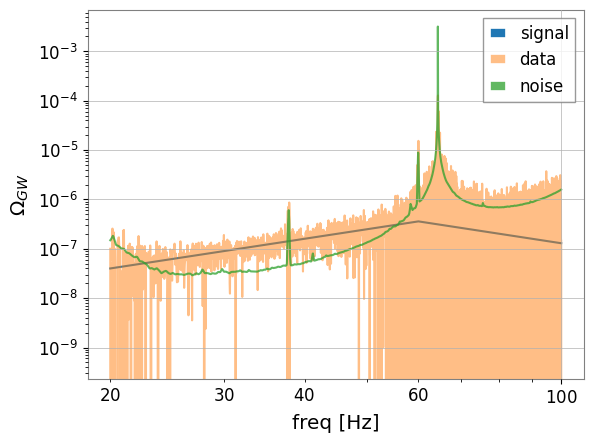

In [62]:
# defaulting to using HL A+ noise curve, can also use CE just as easily
signal, data, data_obj = generate_data(sig_type, freqs, HL_sigma)

# plotting signal, data, noise
plt.loglog(freqs, signal, label = 'signal')
plt.loglog(freqs, data, alpha = 0.5, label = 'data')
plt.loglog(freqs, HL_sigma, alpha=0.75, label='noise')
plt.xlabel('freq [Hz]')
plt.ylabel('$\Omega_{GW}$')
plt.legend()
plt.show()

# Sampling Via RJMCMC

 33%|███▎      | 32769/100000 [00:16<00:31, 2140.23it/s]/home/tknapp/.local/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:305: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
 49%|████▊     | 48679/100000 [00:24<00:27, 1860.98it/s]/tmp/ipykernel_1648677/1456436447.py:69: RuntimeWarning: overflow encountered in power
  omega_model = 10**self.evaluate_interp_model(np.log10(self.data.data_xvals), heights, config, np.log10(knots))
/home/tknapp/.local/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2029: RuntimeWarning: overflow encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
100%|██████████| 100000/100000 [00:52<00:00, 1891.47it/s]


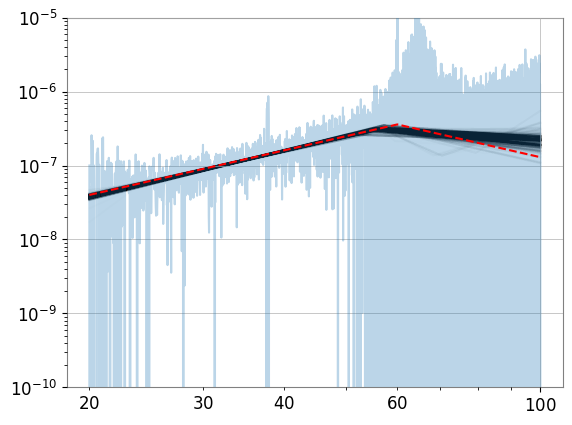

In [63]:
# sample RJMCMC
fit_omega, fit_results_omega = sample_Omega(freqs, N_samples, data_obj)

# plotting a number of the posterior fits to check that they align with the injected signal
plot_posterior_fits(fit_omega, fit_results_omega, freqs, N_samples, offset=N_offset, num_posteriors=1000)

# plotting injected signal and data
plt.plot(freqs, data, alpha=0.3, label='Data', zorder=1000)
plt.plot(freqs, signal, c='r', ls='--', label='True signal', zorder=1001)
plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-10, 1e-5)
plt.xlabel('freqs [Hz]')
plt.ylabel('$\Omega_{GW}$')
plt.show()
             

# Diagnostics for Results

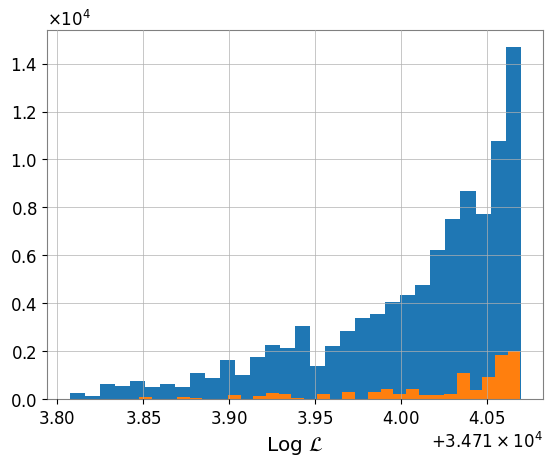

In [68]:
# plotting the log likelihoods for all samples v. offset for burn-in
plt.hist(return_lls(fit_omega, fit_results_omega, freqs, signal, N_samples), bins=30)
plt.hist(return_lls(fit_omega, fit_results_omega, freqs, signal, N_samples, offset=N_offset), bins=30)
plt.xlabel('Log $\mathcal{L}$')
plt.show()

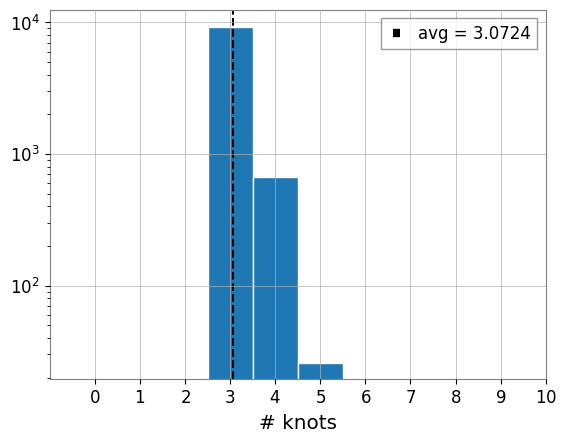

In [77]:
# get the configurations and number of knots
configs, num_knots = return_knot_info(fit_results_omega, offset=N_offset)

# plot histogram of number of knots turned on
plt.hist(num_knots, bins=np.linspace(-0.5, 30.5, num=32), edgecolor='w')
plt.axvline(np.average(num_knots), label = 'avg = '+str(np.average(num_knots)), linestyle='--', c='black')
plt.xticks(np.arange(0, 30))
plt.yscale("log")
plt.xlim(-1, 10)
plt.xlabel('# knots')
plt.legend()
plt.show()

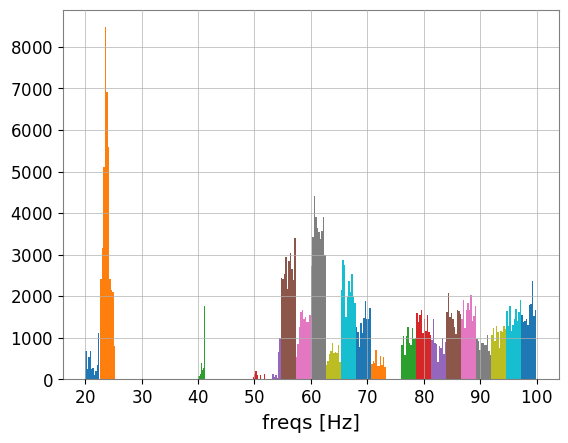

In [70]:
# plotting histogram of horizontal knot placement, should recover vertices in the injected signal
edges, weights = return_knot_placements(fit_results_omega, offset=N_offset)
plt.xlabel('freqs [Hz]')
plt.show()

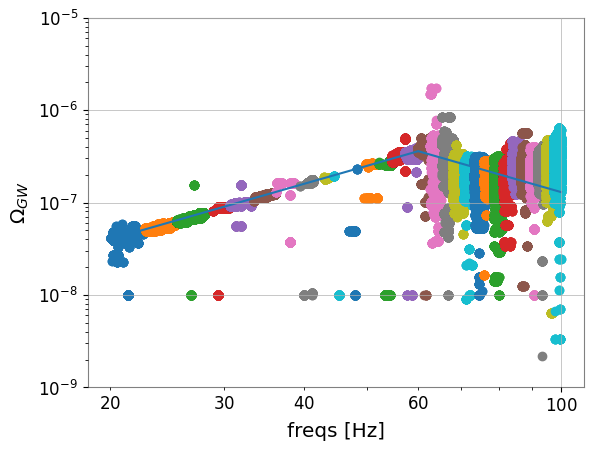

In [73]:
# plotting the knot placements over the injected signal 
# use toggle boolean to plot all knot placements regardless of configuration or only knots turned on
knot_heights = return_knot_heights(fit_results_omega, offset=N_offset)
plot_knot_placements(freqs, signal, fit_results_omega, offset=0, toggle=True)
    